![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Deep Convolutional GAN (DCGAN)

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## MNIST dataset

In [ ]:
!wget https://www.dropbox.com/s/3vm9pavwc59i4cu/MNIST.zip
!unzip MNIST.zip

--2023-10-25 16:30:37--  https://www.dropbox.com/s/3vm9pavwc59i4cu/MNIST.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/3vm9pavwc59i4cu/MNIST.zip [following]
--2023-10-25 16:30:38--  https://www.dropbox.com/s/raw/3vm9pavwc59i4cu/MNIST.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2ab587d3a022d8be9417305e3.dl.dropboxusercontent.com/cd/0/inline/CGQsnwcIlQV3VrOW5Z8N7Kgsoao2USq4KwJQpYjGtYZNb5Jmabi4eE2kCsjSii7bPvh_NgIpboofhE7JURxYw5clUjRI0vOQXsbLdlIJvKdAPHkUkYS8jTV_23kA5q9B2do/file# [following]
--2023-10-25 16:30:38--  https://ucf2ab587d3a022d8be9417305e3.dl.dropboxusercontent.com/cd/0/inline/CGQsnwcIlQV3VrOW5Z8N7Kgsoao2USq4KwJQpYjGtYZNb5Jmabi4eE2kCsjSii7bPvh_NgIpboofhE7JURxYw5clUjRI0vOQXsbLdlIJvKdAPHkUkYS8jTV_23kA5q9B2do/

## Generator

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
        #       4) If its the final layer, use a Tanh activation after the deconvolution.
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''

        if not final_layer:
            return nn.Sequential(
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else: # Final Layer
            return nn.Sequential(
        #       1) Add a convolutional layer using the given parameters.
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.8364703063368796, discriminator loss: 0.5568345894813529


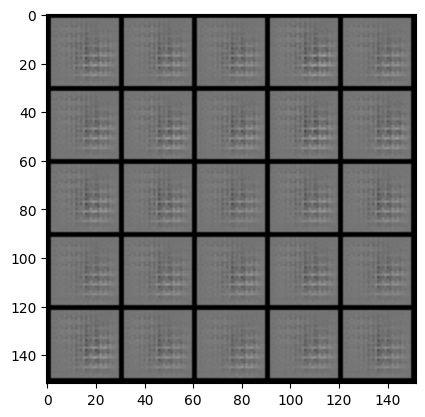

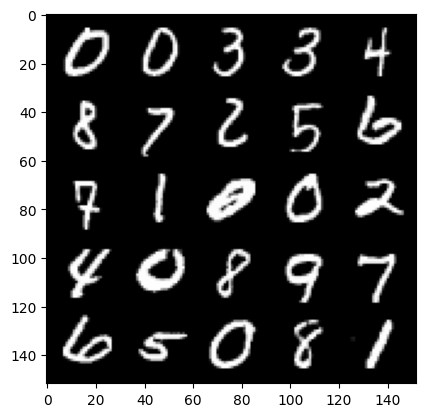

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.8669942386150384, discriminator loss: 0.22238538934290425


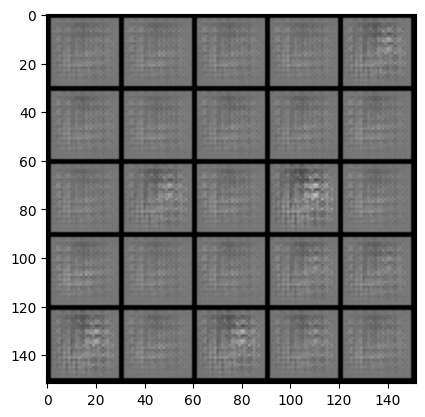

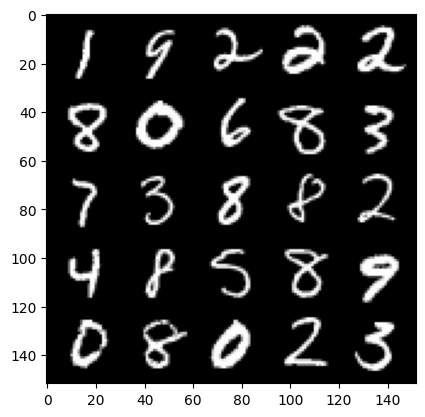

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.461793664216995, discriminator loss: 0.1788350090608001


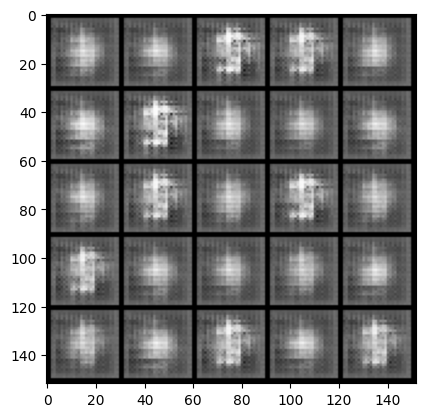

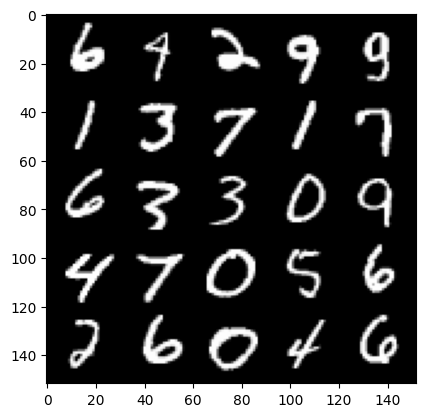

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.9015412744879725, discriminator loss: 0.33608424098789685


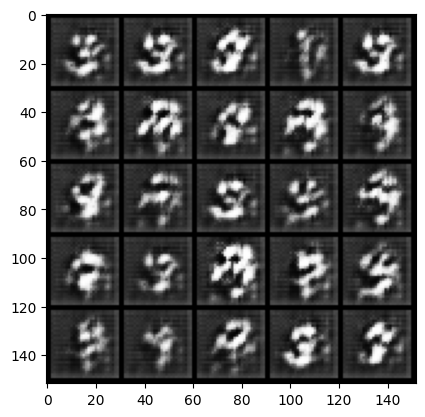

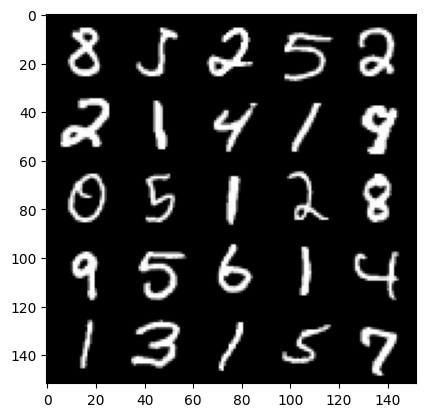

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.2250694708824177, discriminator loss: 0.5009725855588913


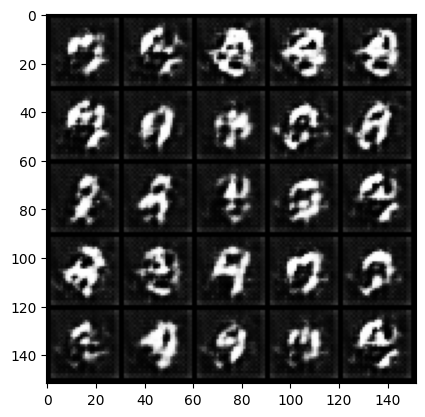

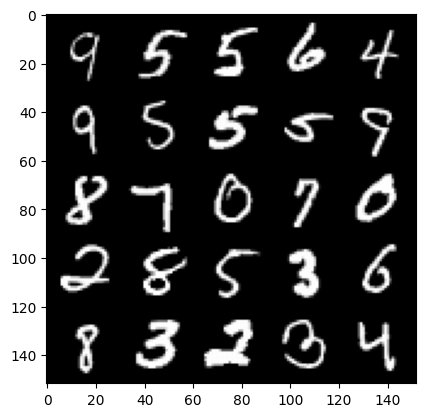

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.022478324204684, discriminator loss: 0.5500129905343055


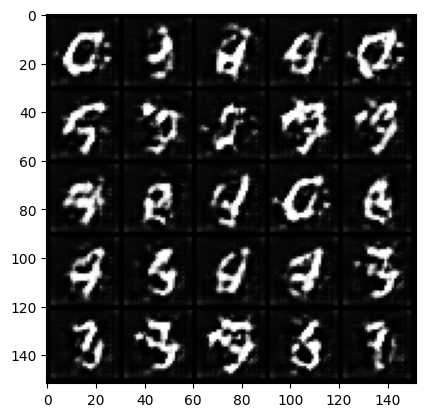

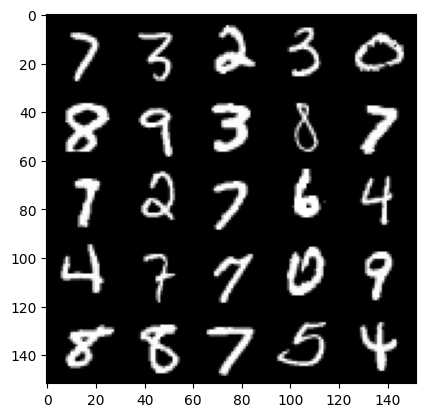

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.9161009418964389, discriminator loss: 0.5903785631656644


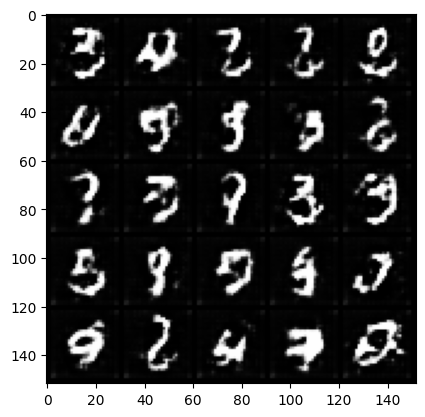

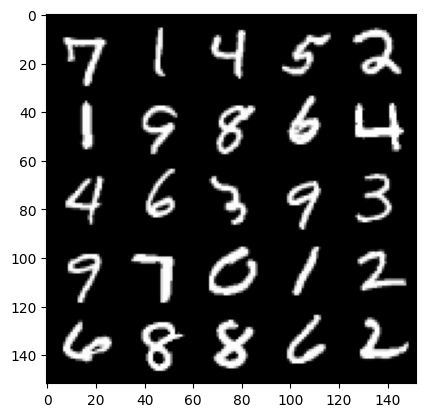

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.8214816434383397, discriminator loss: 0.6332778898477553


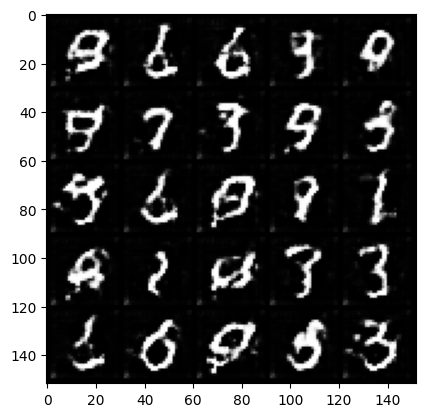

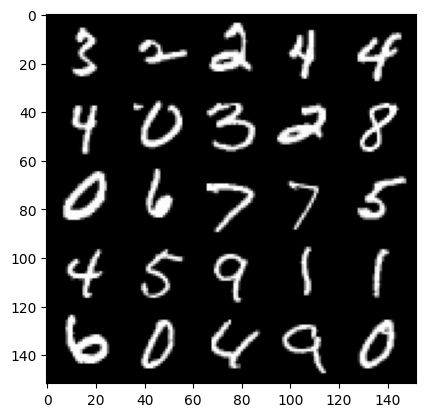

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7994275705814355, discriminator loss: 0.646406363010407


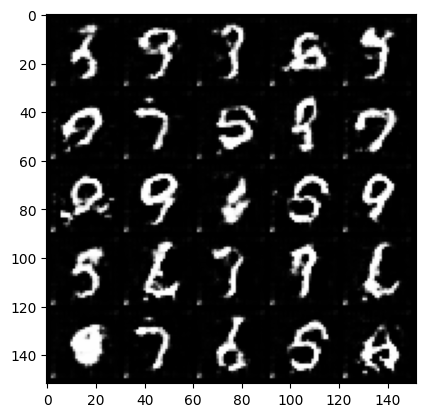

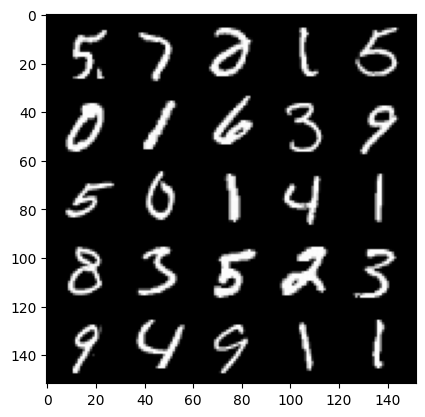

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.7839913030862808, discriminator loss: 0.6518533436059961


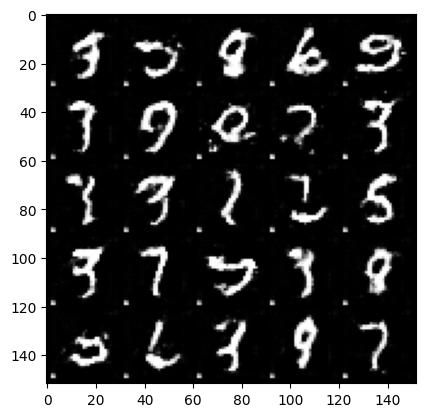

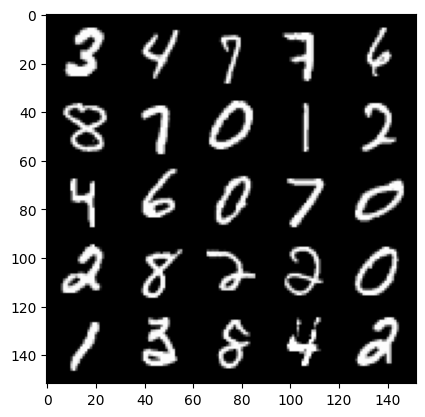

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7944247747063641, discriminator loss: 0.6526371254920954


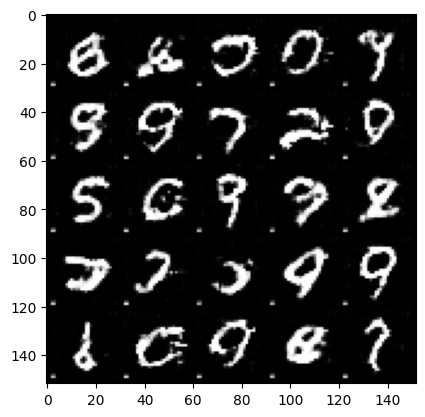

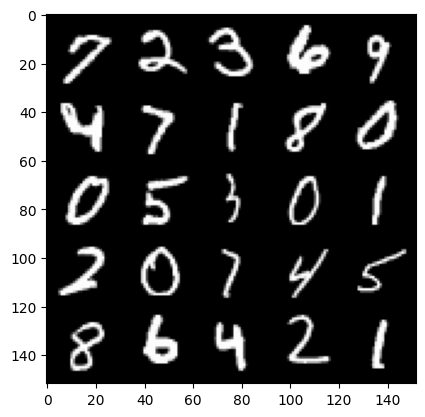

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7811791574358946, discriminator loss: 0.6587809298038477


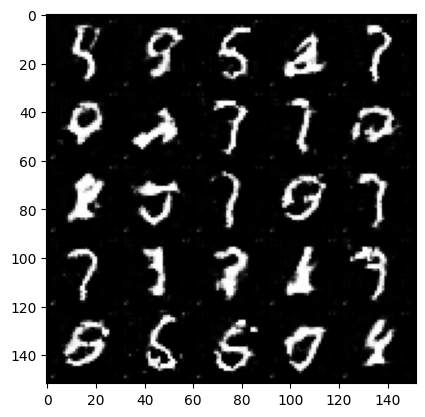

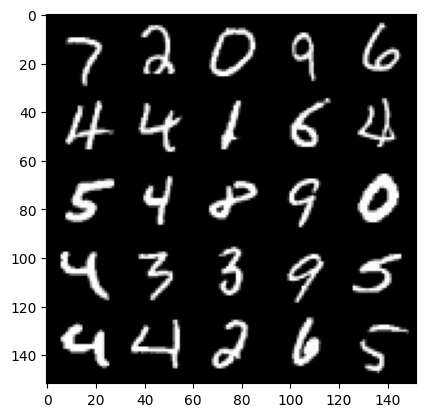

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7832546203732502, discriminator loss: 0.6619137716293337


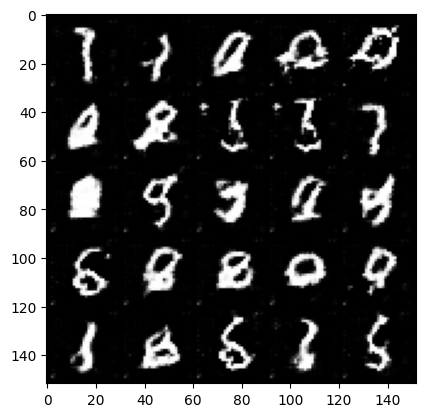

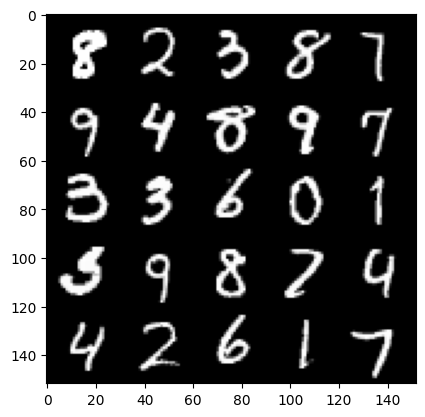

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.777315766513347, discriminator loss: 0.6650078511238104


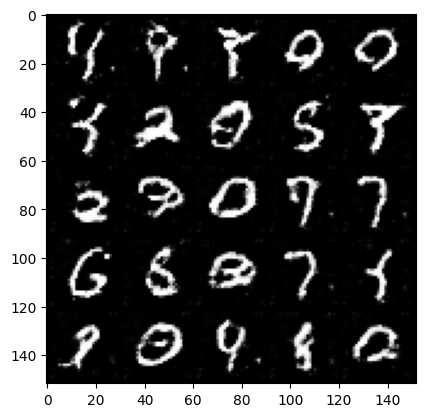

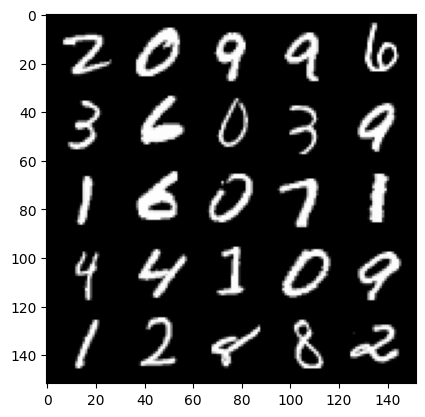

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7754869930744172, discriminator loss: 0.6686571595668789


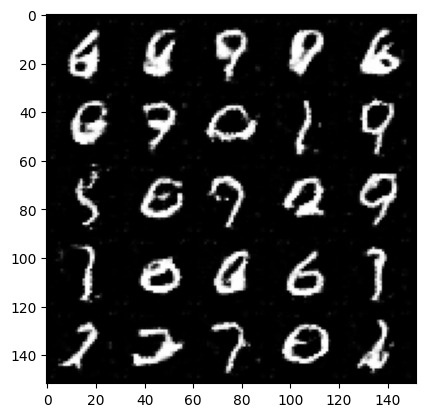

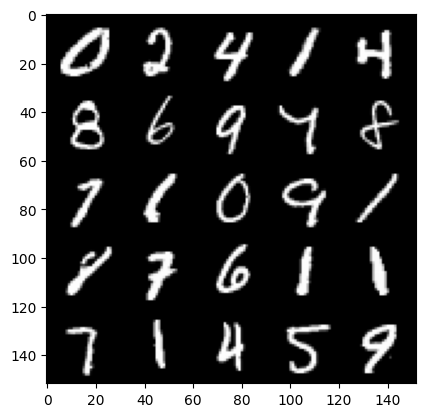

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7692611188292499, discriminator loss: 0.6696240584850311


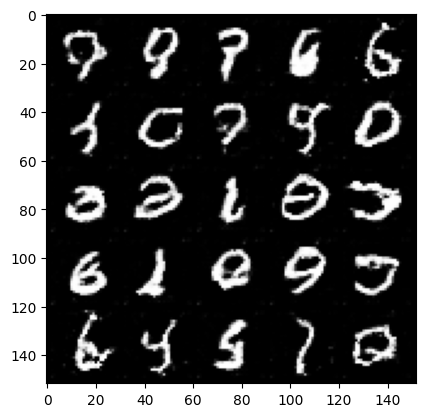

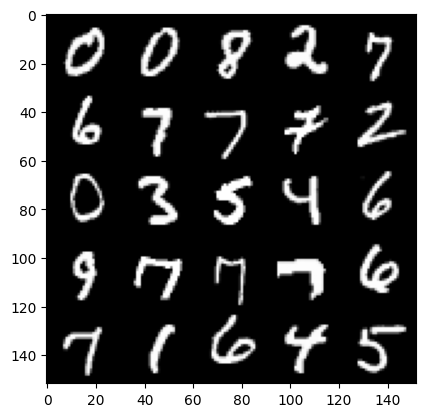

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7639084331989286, discriminator loss: 0.676662103652954


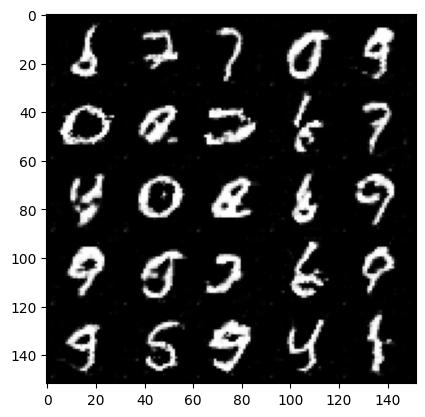

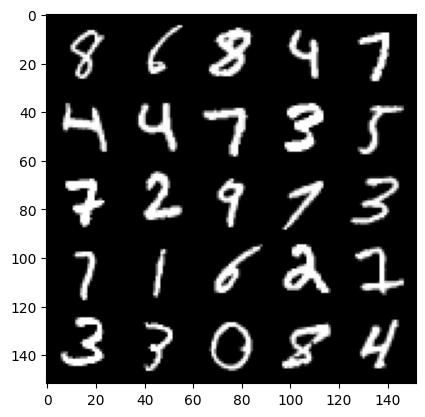

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7578178799152382, discriminator loss: 0.6789993289709099


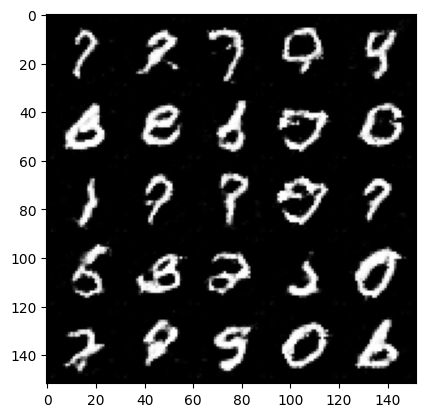

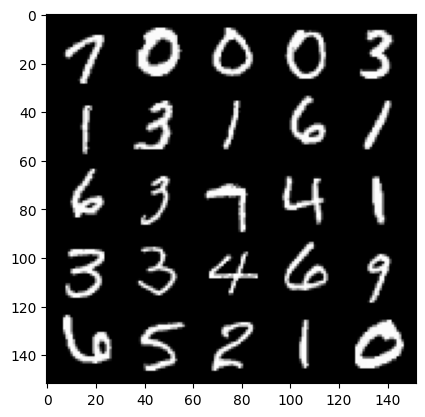

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7486624517440794, discriminator loss: 0.68339906179905


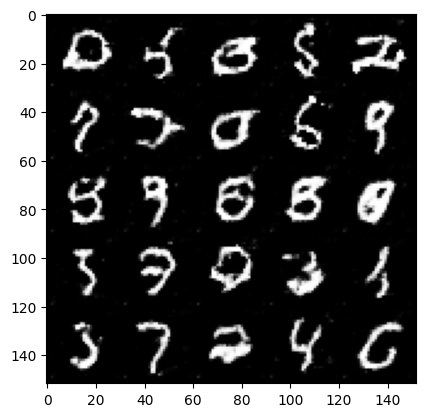

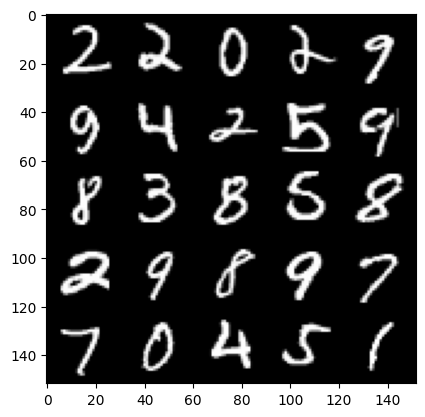

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
